In [ ]:
import pandas as pd
from copy import deepcopy
from tqdm import tqdm


import pandas as pd
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

/srv/home/trokhymovych/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dfs = [pd.read_csv(f"../data/2024-04_content_batch_{i}.csv") for i in tqdm(range(1,16))]
df = pd.concat(dfs).reset_index(drop=True)
print([len(d) for d in dfs])
print(len(df))

In [ ]:
# loading text features: 
df_text = pd.read_csv("../data/mlm_text_features.csv")
# loading holdout dataset: 
holdout_test = pd.read_csv("../data/holdout/test_holdout.csv", sep="\t")
revs_check = set(holdout_test.rev)
df_cat_full = pd.read_csv("../data/2024-04_metadata.csv")

/tmp/ipykernel_1995738/3397980861.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cat_full = pd.read_csv("data/2024-04_metadata.csv")


## Attempt to build the catboost model on-top: 


In [4]:
df["is_add"] = df.added.apply(lambda x: x != "{}")
df["is_remove"] = df.removed.apply(lambda x: x != "{}")
df["is_change"] = df.changed.apply(lambda x: x != "{}")
df["is_labels"] = df.labels.apply(lambda x: x != "{}")
df["is_descriptions"] = df.descriptions.apply(lambda x: x != "{}")

tmp_df = deepcopy(df)
df_cat = df_cat_full[df_cat_full.revision_id.isin(set(tmp_df.revision_id))]

In [5]:
y_col = 'revision_is_identity_reverted'

cat_features = [
       'user_is_bot',
       'user_is_anonymous',
       'event_user_groups-bot',
       'event_user_groups-bureaucrat', 'event_user_groups-checkuser',
       'event_user_groups-confirmed', 'event_user_groups-flood',
       'event_user_groups-interface-admin', 'event_user_groups-ipblock-exempt',
       'event_user_groups-propertycreator', 'event_user_groups-rollbacker',
       'event_user_groups-suppress', 'event_user_groups-sysop',
       'event_user_groups-translationadmin', 'event_user_groups-wikidata-staff',
       # 'parent_same_user',  # <- Optional, as thould be implemented on revert risk lib
       # 'taggs'  # <- skipped
]

numeric_features = [
    "user_age",
    "page_seconds_since_previous_revision",
    "page_age",
]

text_features_mean = ["add_score_mean", "remove_score_mean", "change_score_mean"]
text_features_max = ["add_score_max", "remove_score_max", "change_score_max"]

In [6]:
# Features preparation:

NUMERIC_NaN = -999
CATEGORICAL_NaN = "NaN"

## Text features: 
bert_scores_mean_dict = df_text.groupby(["revision_id", "action_type"]).scores.mean().to_dict()
bert_scores_max_dict = df_text.groupby(["revision_id", "action_type"]).scores.max().to_dict()

df_cat["add_score_mean"] = df_cat.revision_id.apply(lambda x: bert_scores_mean_dict.get((x, 'add: '), NUMERIC_NaN))
df_cat["remove_score_mean"] = df_cat.revision_id.apply(lambda x: bert_scores_mean_dict.get((x, 'remove: '), NUMERIC_NaN))
df_cat["change_score_mean"] = df_cat.revision_id.apply(lambda x: bert_scores_mean_dict.get((x, 'change: '), NUMERIC_NaN))

df_cat["add_score_max"] = df_cat.revision_id.apply(lambda x: bert_scores_max_dict.get((x, 'add: '), NUMERIC_NaN))
df_cat["remove_score_max"] = df_cat.revision_id.apply(lambda x: bert_scores_max_dict.get((x, 'remove: '), NUMERIC_NaN))
df_cat["change_score_max"] = df_cat.revision_id.apply(lambda x: bert_scores_max_dict.get((x, 'change: '), NUMERIC_NaN))

## Categorical Features Renaming: 
df_cat["user_is_bot"] = df_cat["is_bot"]
df_cat["user_is_anonymous"] = df_cat["event_user_is_anonymous"]


# Filling NaNs:
df_cat[cat_features] = df_cat[cat_features].astype(str).fillna(CATEGORICAL_NaN)
df_cat[numeric_features] = df_cat[numeric_features].fillna(NUMERIC_NaN)

ids_to_drop = df[(df.revision_is_identity_reverted == True) & ((df.self_revert) | (df.reverting_revision_is_reverted_revision))]["revision_id"].values
ids_train = df[
    (pd.to_datetime(df['event_timestamp']) < pd.to_datetime('2023-06-01')) & 
    (pd.to_datetime(df['event_timestamp']) > pd.to_datetime('2021-09-01'))
].revision_id
ids_holdout = df[
    (pd.to_datetime(df['event_timestamp']) > pd.to_datetime('2023-06-01')) & 
    (pd.to_datetime(df['event_timestamp']) < pd.to_datetime('2023-09-01'))
].revision_id

test = df_cat[~df_cat.revision_id.isin(ids_to_drop)]  # Filter self reverts
test = test[~test.revision_id.isin(revs_check)]  # filter experts scores
test = test[test.revision_id.isin(ids_holdout)]  # filter time

val = df_cat[df_cat.revision_id.isin(revs_check)]

/tmp/ipykernel_1995738/3500017262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["add_score_mean"] = df_cat.revision_id.apply(lambda x: bert_scores_mean_dict.get((x, 'add: '), NUMERIC_NaN))
/tmp/ipykernel_1995738/3500017262.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat["remove_score_mean"] = df_cat.revision_id.apply(lambda x: bert_scores_mean_dict.get((x, 'remove: '), NUMERIC_NaN))
/tmp/ipykernel_1995738/3500017262.py:12: SettingWithCopyWarning: 
A value is trying to be set on a c

In [7]:
len(val)

1293

In [8]:
len(test)

645264

In [ ]:
model_text = CatBoostClassifier().load_model('../models/graph2text_full_new.cbn')
model_text_only = CatBoostClassifier().load_model('../models/graph2text_only_full_new.cbn')
model_dummy = CatBoostClassifier().load_model('../models/dummy_full_new.cbn')

In [10]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def precision_at_recall(y_true, y_scores, recall_thr=0.75):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    idx = np.where(recall > recall_thr)[0][-1]
    return precision[idx]

def filter_rate_at_high_recall(y_true, y_prob, desired_recall):
    """
    Calculate the filter-rate at high recall.
    
    :param y_true: List or array of true labels (1 for vandalism, 0 for non-vandalism)
    :param y_prob: List or array of predicted probabilities for the positive class (vandalism)
    :param desired_recall: The desired recall level (e.g., 0.95 for 95% recall)
    :return: The filter-rate (proportion of edits that must be reviewed)
    """
    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    # Find the threshold that achieves the desired recall
    threshold = None
    for i in range(len(recalls)):
        if recalls[i] < desired_recall:
            threshold = thresholds[i-1]
            break
            
    if threshold is None:
        raise ValueError("Desired recall level not achievable. Lower the desired recall.")
    
    # Apply the threshold to get binary predictions
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate the filter rate (1 - proportion of items predicted as positive)
    filter_rate = 1 - np.mean(y_pred)
    
    return filter_rate

def draw_bs_replicates(true, pred, func, sample_size, n_samples):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(n_samples)
    np_true = np.array(true)
    np_pred = np.array(pred)
    # Create bootstrap replicates as much as size
    for i in range(n_samples):
        np.random.seed(i)
        # Create a bootstrap sample
        bs_sample_index = np.random.randint(0, high=len(true), size=sample_size)
        true_sample = np_true[bs_sample_index]
        pred_sample = np_pred[bs_sample_index]
        bs_replicates[i] = func(true_sample, pred_sample)
    return bs_replicates

def calculate_metrics(true_label, predicted_scores, threshold=0.5, verbose=True): 
    # Calculating AUC (main metric)
    auc_score = roc_auc_score(true_label, predicted_scores)
    if verbose: 
        print("AUC: ", round(auc_score, 3))
    
    samples_res = draw_bs_replicates(true_label, predicted_scores, roc_auc_score, 10000, 1000)
    return (
        np.mean(samples_res),
        [np.percentile(samples_res, 5), np.percentile(samples_res, 95)],
        filter_rate_at_high_recall(true_label, predicted_scores, 0.9),
        filter_rate_at_high_recall(true_label, predicted_scores, 0.7),
        filter_rate_at_high_recall(true_label, predicted_scores, 0.5),
    )

In [ ]:
expert_val = pd.read_csv("../data/expert_scores.csv", sep="\t")
expert_val.drop_duplicates(inplace=True)

expert_val = expert_val[~expert_val.rev.isin([1923800406, 1930087371])] # duplicated records that have the different label
expert_val.head()

,wiki_db,rev,prediction,probability,label
0,wikidata,1954633434,False,0.492595,Keep
1,wikidata,1927222417,True,0.588389,Keep
2,wikidata,1962156438,True,0.850833,Not Sure
3,wikidata,1922333339,True,0.801237,Keep
4,wikidata,1945811900,True,0.700098,Not Sure


In [ ]:
ores_scores = pd.read_csv("../data/ores_scores.csv")
ores_scores_dict = {int(k):v for k,v in zip(ores_scores.revision_id, ores_scores.pred)}
test["ores_pred"] = test.revision_id.map(ores_scores_dict)
val["ores_pred"] = val.revision_id.map(ores_scores_dict)

expert_val["ores_pred"] = expert_val.rev.map(ores_scores_dict)

/tmp/ipykernel_1995738/842098340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["ores_pred"] = val.revision_id.map(ores_scores_dict)


In [13]:
scores = model_dummy.predict_proba(test[model_dummy.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(test.revision_id.values, scores)}
test["model_dummy_pred"] = test.revision_id.map(scores_dict)
expert_val["model_dummy_pred"] = expert_val.rev.map(scores_dict)

scores = model_dummy.predict_proba(val[model_dummy.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(val.revision_id.values, scores)}
val["model_dummy_pred"] = val.revision_id.map(scores_dict)



/tmp/ipykernel_1995738/1754925604.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["model_dummy_pred"] = val.revision_id.map(scores_dict)


In [14]:
scores = model_text.predict_proba(test[model_text.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(test.revision_id.values, scores)}
test["model_text_pred"] = test.revision_id.map(scores_dict)
expert_val["model_text_pred"] = expert_val.rev.map(scores_dict)

scores = model_text.predict_proba(val[model_text.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(val.revision_id.values, scores)}
val["model_text_pred"] = val.revision_id.map(scores_dict)


/tmp/ipykernel_1995738/1540730408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["model_text_pred"] = val.revision_id.map(scores_dict)


In [15]:
scores = model_text_only.predict_proba(test[model_text_only.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(test.revision_id.values, scores)}
test["model_text_only_pred"] = test.revision_id.map(scores_dict)
expert_val["model_text_only_pred"] = expert_val.rev.map(scores_dict)

scores = model_text_only.predict_proba(val[model_text_only.feature_names_])[:, 1]
scores_dict = {k: v for k, v in zip(val.revision_id.values, scores)}
val["model_text_only_pred"] = val.revision_id.map(scores_dict)


/tmp/ipykernel_1995738/3333753899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["model_text_only_pred"] = val.revision_id.map(scores_dict)


In [16]:
test["rule_based_pred"] = (test.user_is_anonymous == "True").astype(int)
val["rule_based_pred"] = (val.user_is_anonymous == "True").astype(int)

/tmp/ipykernel_1995738/2249884446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val["rule_based_pred"] = (val.user_is_anonymous == "True").astype(int)


In [17]:
import shap

test_data = Pool(
    data=test[model_text.feature_names_],
    label=test[y_col].astype(int),
    cat_features=cat_features
)

shap.initjs()
explainer = shap.TreeExplainer(model_text)
shap_values = explainer.shap_values(test_data)

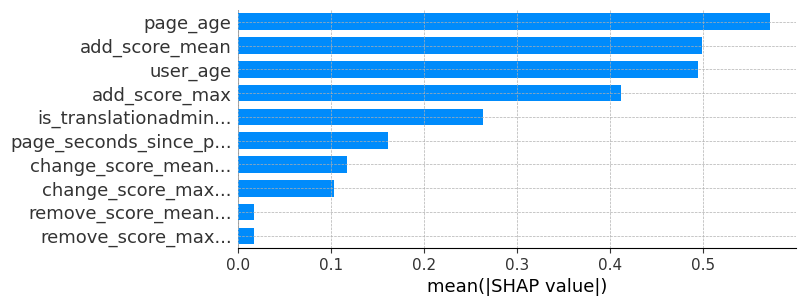

In [18]:
import matplotlib.pyplot as plt
# Get feature names and truncate them (limit to first 15 characters, for example)
feature_names = [name.replace("event_user_groups-", "is_")[:20] + '...' if len(name) > 15 else name for name in model_text.feature_names_]

# Convert test data into a DataFrame with truncated feature names
test_truncated = pd.DataFrame(test, columns=feature_names)
# Customize and create the summary plot with top 10 features and truncated names
plt.figure(figsize=(12, 1))  # Adjust figure size for better readability
shap.summary_plot(shap_values, test_truncated, plot_type="bar", max_display=10, show=False, plot_size=(8,3))
# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reduce the space between the bars by adjusting y-axis ticks and limits
plt.gca().tick_params(axis='y', pad=1)  # Adjust padding between ticks
plt.tight_layout(pad=0.5)  # Reduce extra padding around the plot
plt.gca().set_ylim([-0.5, 9.5])  # Fine-tune the y-axis limits to reduce space between bars

plt.xlabel("mean(|SHAP value|)")

# Save the plot as a high-resolution PNG file
plt.savefig("shap_summary_plot_top10.png", dpi=500, bbox_inches="tight")  # dpi=300 ensures high resolution
plt.show()


In [19]:
len(model_text.feature_names_)

24

In [20]:
test = test[~test.ores_pred.isna()]

metrics = [
    calculate_metrics(test.revision_is_identity_reverted, test.rule_based_pred, verbose=False),
    calculate_metrics(test.revision_is_identity_reverted, test.ores_pred, verbose=False),
    calculate_metrics(test.revision_is_identity_reverted, test.model_dummy_pred, verbose=False),
    calculate_metrics(test.revision_is_identity_reverted, test.model_text_only_pred, verbose=False),
    calculate_metrics(test.revision_is_identity_reverted, test.model_text_pred, verbose=False),
]

pd.DataFrame(metrics, columns=["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"])

,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.759601,"[0.7432473021782129, 0.7757274278162549]",0.000000,0.000000,0.916577
1,0.859129,"[0.8436395243012986, 0.8730942552081974]",0.447725,0.876890,0.938797
2,0.880180,"[0.8672952857203856, 0.8924149114873788]",0.552055,0.889704,0.938594
3,0.876479,"[0.8643898463898879, 0.8881113284780545]",0.595991,0.824576,0.931831
4,0.923539,"[0.9138632054099128, 0.9326050857794024]",0.709038,0.911492,0.958279


In [21]:
# Expert evaluation metrics: 
display(expert_val.label.value_counts())
expert_val_filtered = expert_val[expert_val.label != "Not Sure"]
expert_val_filtered["revision_is_identity_reverted"] = expert_val_filtered.label.apply(lambda x: 1 if x == "Revert" else 0)

metrics = [
    calculate_metrics(expert_val_filtered.revision_is_identity_reverted, expert_val_filtered.ores_pred, verbose=False),
    calculate_metrics(expert_val_filtered.revision_is_identity_reverted, expert_val_filtered.model_dummy_pred, verbose=False),
    calculate_metrics(expert_val_filtered.revision_is_identity_reverted, expert_val_filtered.model_text_only_pred, verbose=False),
    calculate_metrics(expert_val_filtered.revision_is_identity_reverted, expert_val_filtered.model_text_pred, verbose=False),
]

pd.DataFrame(metrics, columns=["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"], index = ["ORES", "MbC", "CbC", "Graph2Text"])

label
Keep        650
Not Sure    240
Revert      105
Name: count, dtype: int64

/tmp/ipykernel_1995738/1221439962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_val_filtered["revision_is_identity_reverted"] = expert_val_filtered.label.apply(lambda x: 1 if x == "Revert" else 0)


,AUC,±CI,RF0.99,RF0.9,RF0.7
ORES,0.885408,"[0.8785289512544674, 0.8920239232188086]",0.593377,0.798675,0.880795
MbC,0.853624,"[0.8455795207720983, 0.8611382523208033]",0.549669,0.750993,0.852980
CbC,0.863251,"[0.8541232504971432, 0.8720111411924311]",0.495364,0.782781,0.883444
Graph2Text,0.932001,"[0.9263860564654421, 0.9371831850889203]",0.698013,0.846358,0.917881


In [22]:
print(pd.DataFrame(metrics, columns=["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"], index = ["ORES", "MbC", "CbC", "Graph2Text"]).round(3).to_latex())

\begin{tabular}{lrlrrr}
\toprule
 & AUC & ±CI & RF0.99 & RF0.9 & RF0.7 \\
\midrule
ORES & 0.885000 & [0.8785289512544674, 0.8920239232188086] & 0.593000 & 0.799000 & 0.881000 \\
MbC & 0.854000 & [0.8455795207720983, 0.8611382523208033] & 0.550000 & 0.751000 & 0.853000 \\
CbC & 0.863000 & [0.8541232504971432, 0.8720111411924311] & 0.495000 & 0.783000 & 0.883000 \\
Graph2Text & 0.932000 & [0.9263860564654421, 0.9371831850889203] & 0.698000 & 0.846000 & 0.918000 \\
\bottomrule
\end{tabular}



# Fairness evaluation: 

In [23]:
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
from aif360.sklearn.metrics import disparate_impact_ratio, difference

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculate_metrics_fair(df, col_pred):
    
    df_priv = test[test.user_is_anonymous == "False"]
    df_not_priv = test[test.user_is_anonymous == "True"]
    
    # print(len(df_priv))
    # print(len(df_not_priv))
    
    results_dict = {
        "disparate_impact_ratio_base": df_not_priv.revision_is_identity_reverted.mean() / df_priv.revision_is_identity_reverted.mean(),
        "disparate_impact_ratio": df_not_priv[col_pred].mean() / df_priv[col_pred].mean(), 
        "AUC difference": roc_auc_score(df_priv.revision_is_identity_reverted, df_priv[col_pred]) \
            - roc_auc_score(df_not_priv.revision_is_identity_reverted, df_not_priv[col_pred]),
    }
    return results_dict

calculate_metrics_fair(test, "rule_based_pred")

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


591391
53826


/tmp/ipykernel_1995738/3557093804.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  "disparate_impact_ratio": df_not_priv[col_pred].mean() / df_priv[col_pred].mean(),


{'disparate_impact_ratio_base': 14.5907303495532,
 'disparate_impact_ratio': inf,
 'AUC difference': 0.0}

In [67]:
calculate_metrics_fair(test, "ores_pred")

591391
53826


{'disparate_impact_ratio_base': 14.5907303495532,
 'disparate_impact_ratio': 5.685755383475297,
 'AUC difference': 0.03528562872776486}

In [68]:
calculate_metrics_fair(test, "model_dummy_pred")

591391
53826


{'disparate_impact_ratio_base': 14.5907303495532,
 'disparate_impact_ratio': 4.086871516112111,
 'AUC difference': 0.09671032318017281}

In [69]:
calculate_metrics_fair(test, "model_text_pred")

591391
53826


{'disparate_impact_ratio_base': 14.5907303495532,
 'disparate_impact_ratio': 4.434512549017485,
 'AUC difference': -0.00990924271488347}

In [70]:
calculate_metrics_fair(test, "model_text_only_pred")

591391
53826


{'disparate_impact_ratio_base': 14.5907303495532,
 'disparate_impact_ratio': 2.069568595933279,
 'AUC difference': -0.044126795383558015}

In [24]:
is_anon_filter = test.user_is_anonymous == "True"
test_anon = test[~is_anon_filter]

test_anon["new_user"] = (test_anon["user_age"] < 5).astype(int)
def calculate_metrics_fair(df, col_pred):
    
    df_priv = df[df.new_user == 0]
    df_not_priv = df[df.new_user == 1]
    
    print(len(df_priv))
    print(len(df_not_priv))
    
    results_dict = {
        "disparate_impact_ratio_base": df_not_priv.revision_is_identity_reverted.mean() / df_priv.revision_is_identity_reverted.mean(),
        "disparate_impact_ratio": df_not_priv[col_pred].mean() / df_priv[col_pred].mean(), 
        "AUC difference": roc_auc_score(df_priv.revision_is_identity_reverted, df_priv[col_pred]) \
            - roc_auc_score(df_not_priv.revision_is_identity_reverted, df_not_priv[col_pred]),
    }
    return results_dict

calculate_metrics_fair(test_anon, "ores_pred")

/tmp/ipykernel_1995738/1195406094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_anon["new_user"] = (test_anon["user_age"] < 5).astype(int)


530986
60406


{'disparate_impact_ratio_base': 2.5518909110789423,
 'disparate_impact_ratio': 1.3730022434334785,
 'AUC difference': -0.19348833560512868}

In [25]:
calculate_metrics_fair(test_anon, "model_text_pred")

530986
60406


{'disparate_impact_ratio_base': 2.5518909110789423,
 'disparate_impact_ratio': 1.2431291205162094,
 'AUC difference': -0.09578597015116153}

In [26]:
calculate_metrics_fair(test_anon, "model_text_only_pred")


530986
60406


{'disparate_impact_ratio_base': 2.5518909110789423,
 'disparate_impact_ratio': 1.0837946200394906,
 'AUC difference': -0.027099159254422633}

In [27]:
calculate_metrics_fair(test_anon, "model_dummy_pred")

530986
60406


{'disparate_impact_ratio_base': 2.5518909110789423,
 'disparate_impact_ratio': 1.1547177714045609,
 'AUC difference': -0.15493068090436057}

# Plot Precision Recall plot
# Plot Recall filterrate plot

__________________________________________________


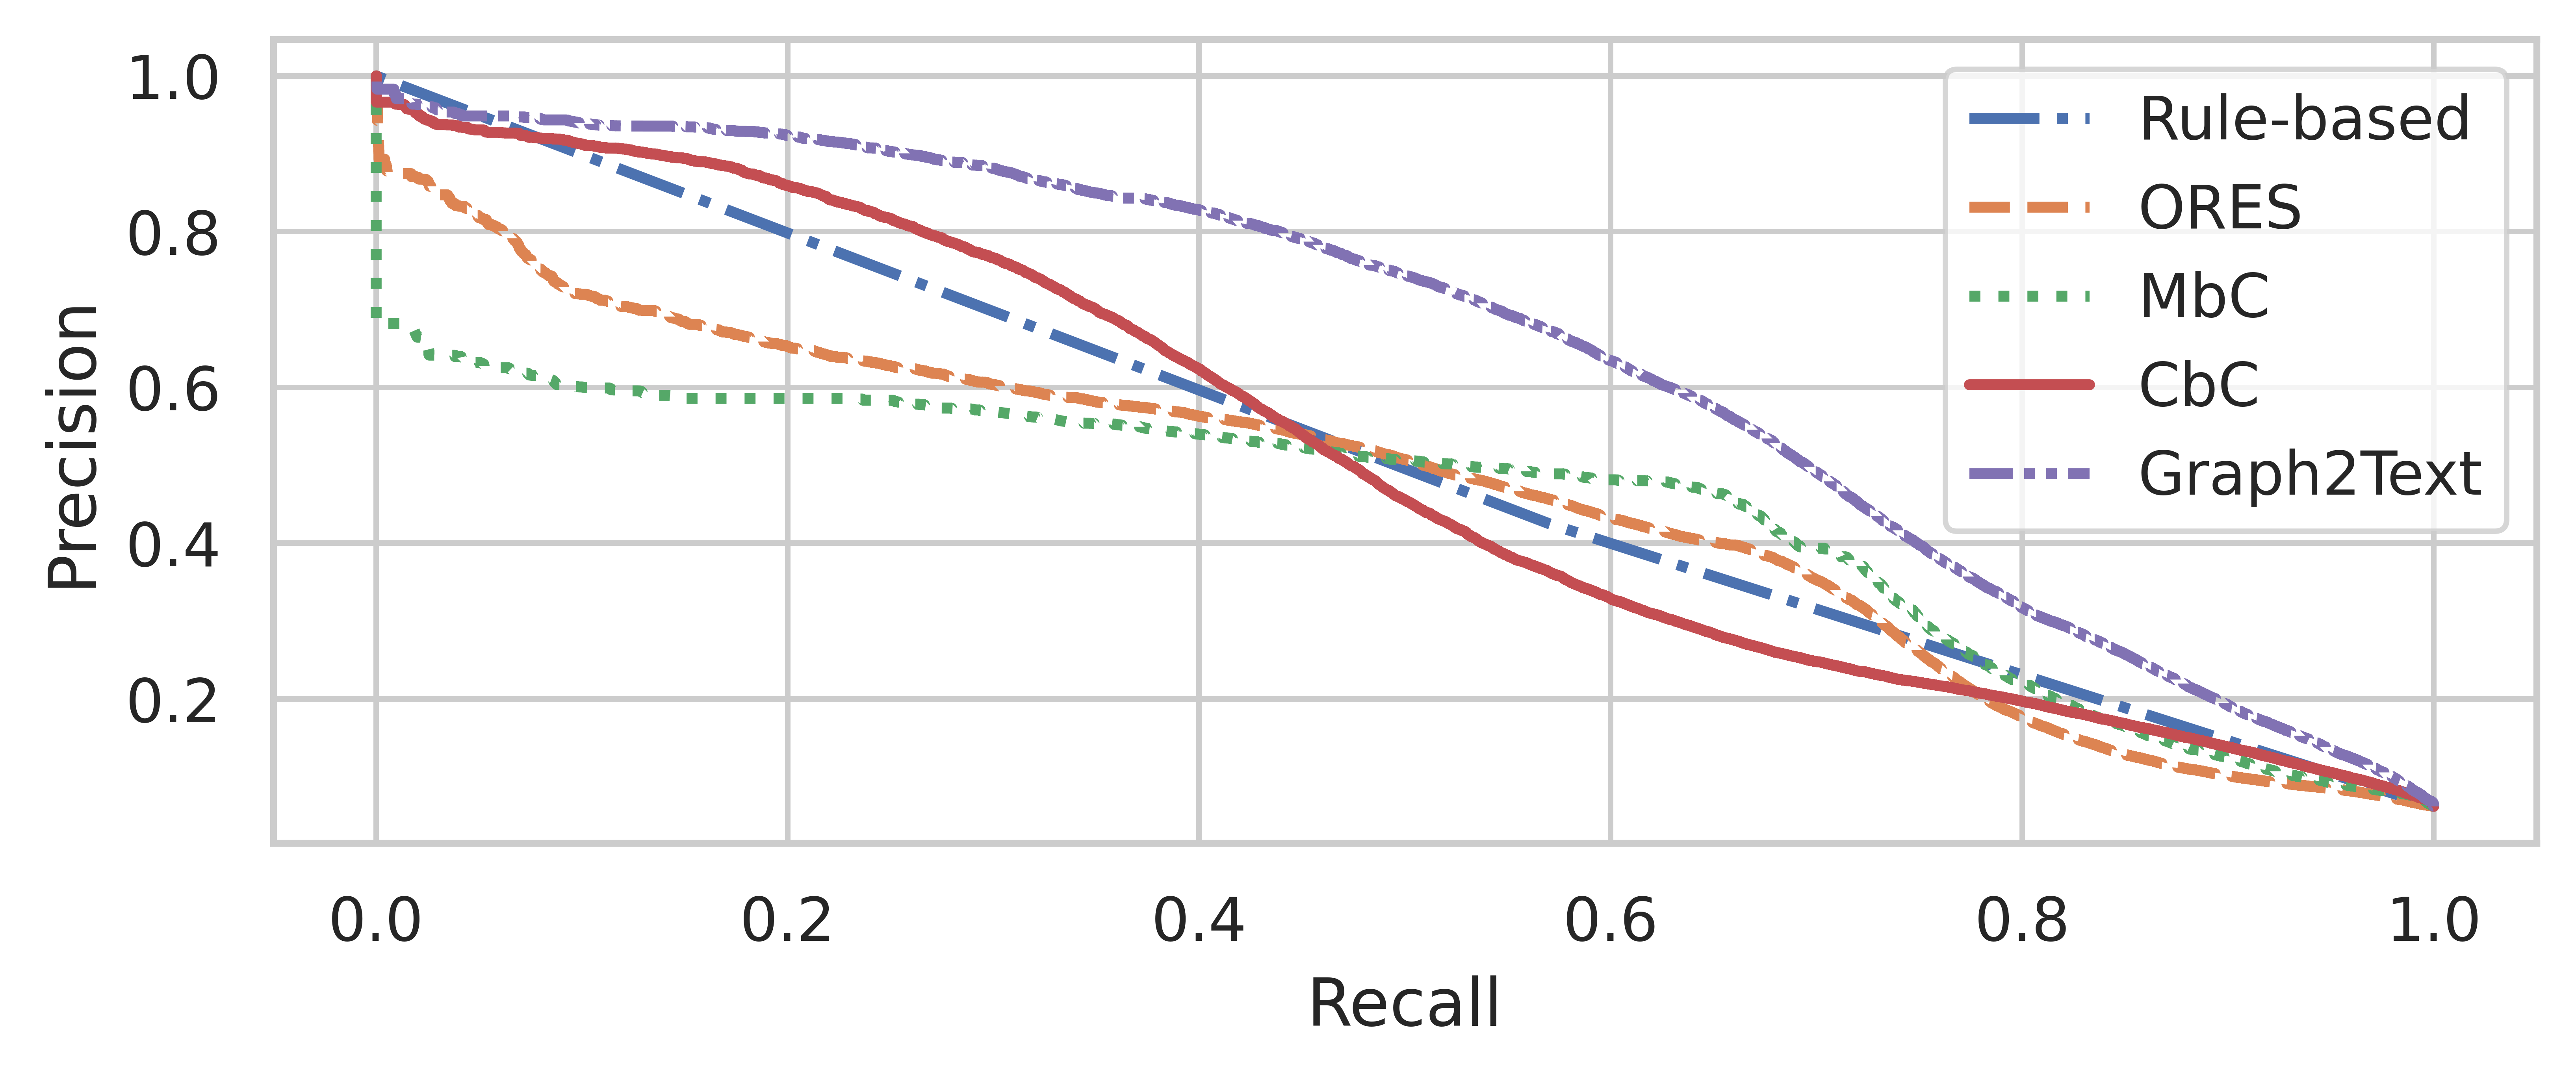

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# figure(figsize=(12, 4), dpi=1000)

NAMES = ["Rule-based", "ORES", "MbC", "CbC", "Graph2Text"]

linestyles = [
    "dashdot", 
    "dashed",
    "dotted", 
    "solid",
    (0, (4, 1, 1, 1, 1, 1)),
    (0, (3, 1, 1, 1)),
    (0, (2, 1, 1, 1, 1, 1, 1, 1))
]

def precision_recall_plot(df):
    target_column = "revision_is_identity_reverted"
    pred_names = ["rule_based_pred", "ores_pred", "model_dummy_pred", "model_text_only_pred", "model_text_pred"]
    def smooth_values(l):
        for i in range(1, len(l)):
            if l[i] < l[i-1]:
                l[i]=l[i-1]
        return l
    
    true = np.array(df[target_column])
    probs = [np.array(df[name]) for name in pred_names]
    
    precisions, recalls = [], []
    for prob in probs:
        precision, recall, _ = precision_recall_curve(true, prob)
        precisions.append(smooth_values(precision))
        recalls.append(recall)

    print("_"*50)

    # plot the precision-recall curves
    no_skill = len(true[true==1]) / len(true)
    # pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    for p, r, n, linestyle in zip(precisions, recalls, NAMES, linestyles):
        pyplot.plot(r, p, linestyle=linestyle, linewidth=2, label=n)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    plt.tight_layout()
    pyplot.savefig('pr_plot.png', dpi=1000,  bbox_inches='tight')

figure(figsize=(6.7, 2.9), dpi=1000)
precision_recall_plot(test)

100%|██████████| 5/5 [16:55<00:00, 203.05s/it]


__________________________________________________


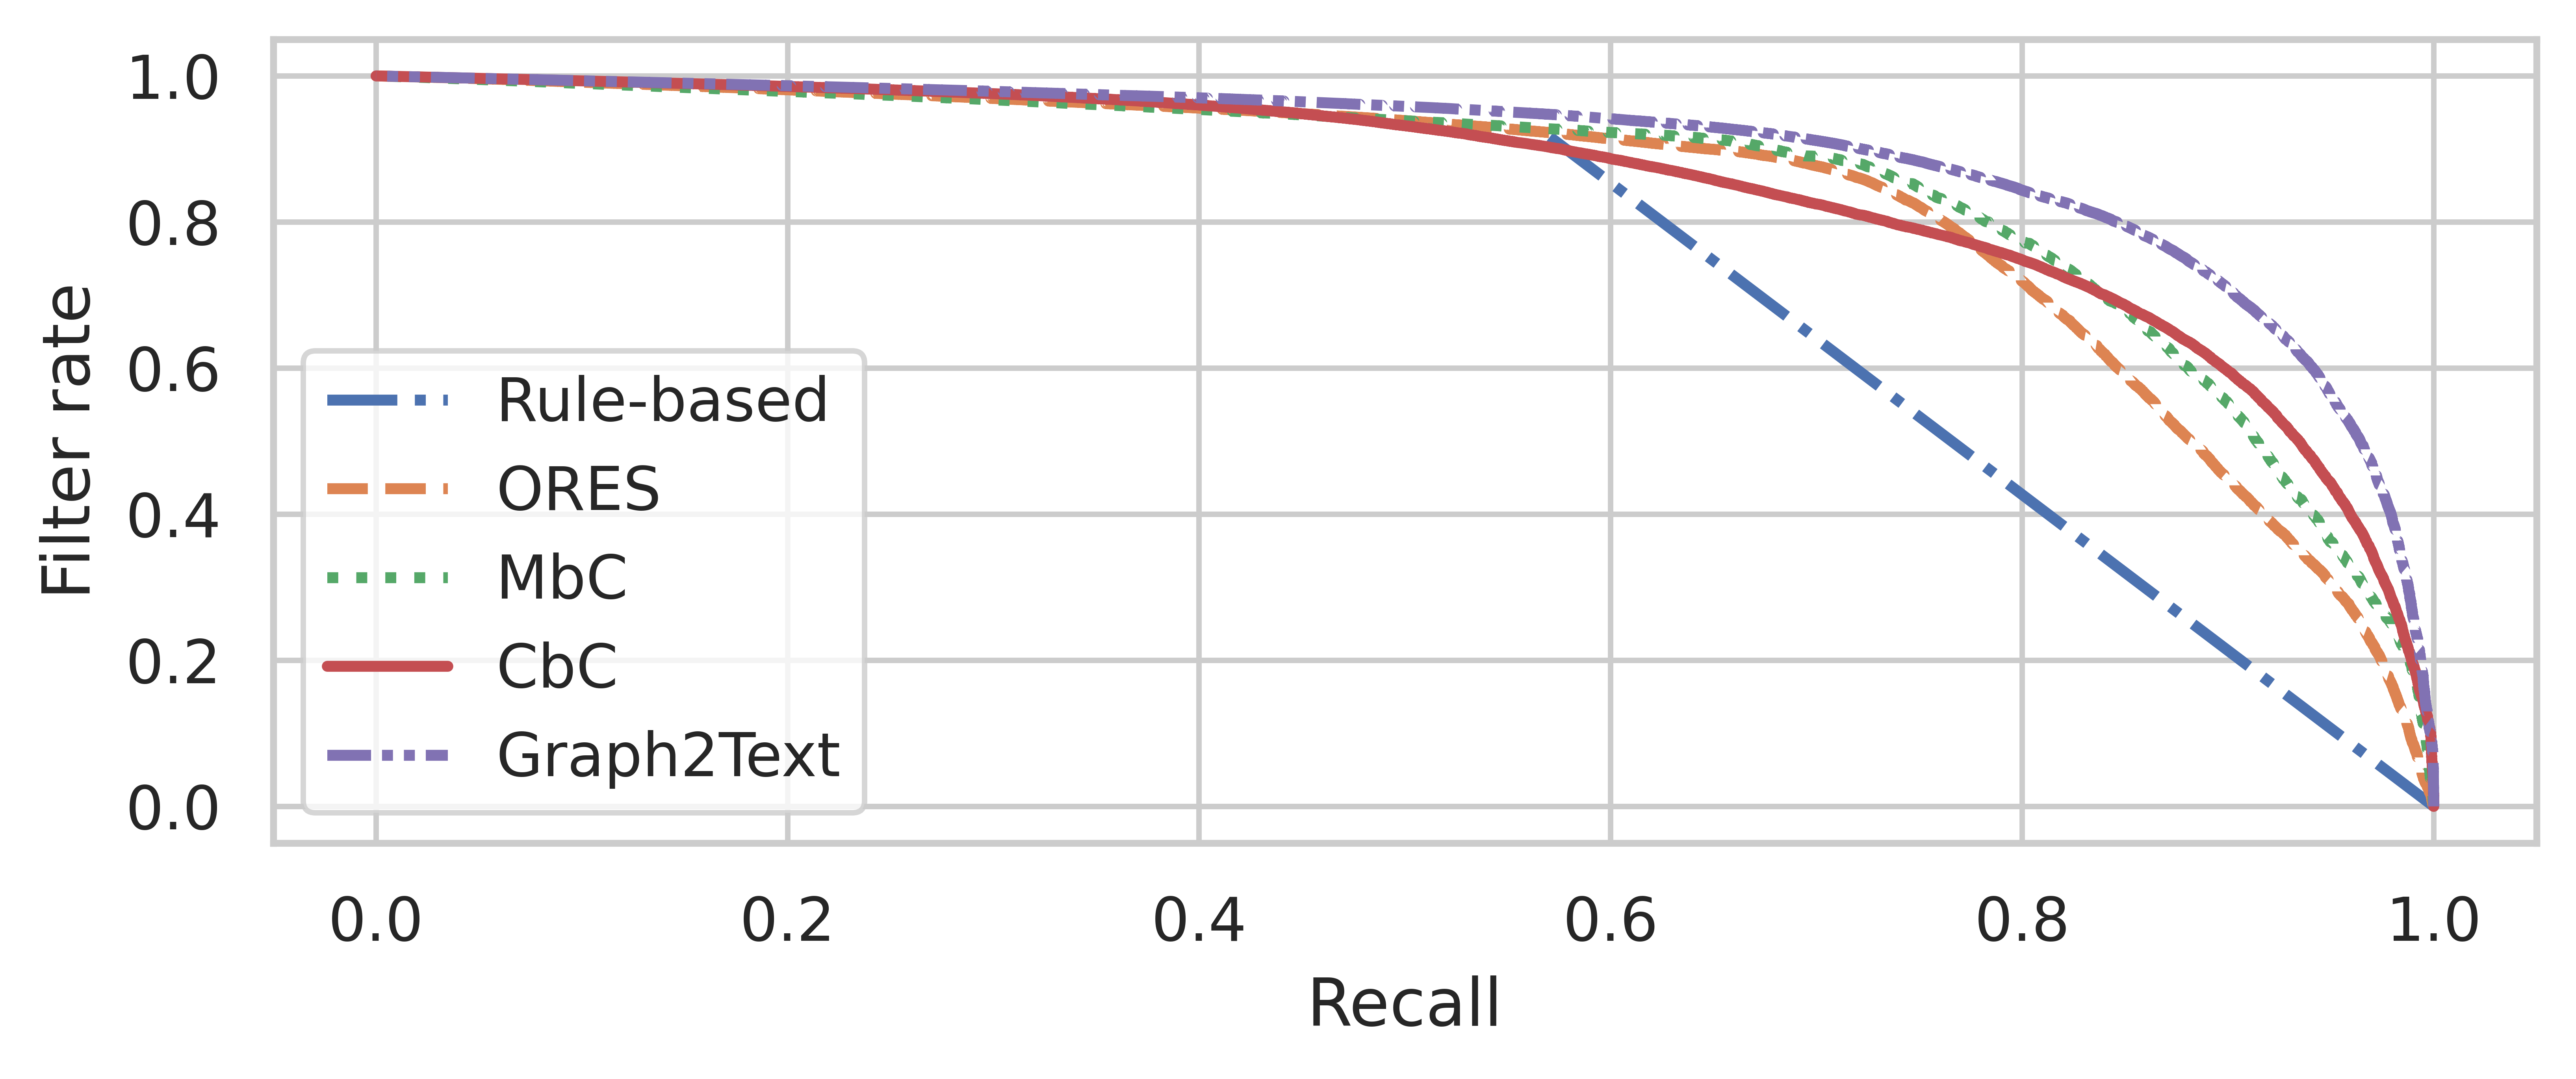

In [79]:
def plot_filter_rate_vs_recall(df):
    target_column = "revision_is_identity_reverted"
    pred_names = ["rule_based_pred", "ores_pred", "model_dummy_pred", "model_text_only_pred", "model_text_pred"]
    
    def smooth_values(l):
        for i in range(1, len(l)):
            if l[i] < l[i-1]:
                l[i]=l[i-1]
        return l
    
    true = np.array(df[target_column])
    probs = [np.array(df[name]) for name in pred_names]
    
    recalls, filter_rates = [], []
    for prob in tqdm(probs):
        precision, recall, thresholds = precision_recall_curve(true, prob)
        filter_rates_ = [1 - np.mean(prob >= threshold) for threshold in thresholds]
        recalls.append(recall)
        filter_rates.append(filter_rates_)
    
    print("_"*50)
    for f, r, n, linestyle in zip(filter_rates, recalls, NAMES, linestyles):
        pyplot.plot(r[:-1], f, linestyle=linestyle, linewidth=2, label=n)
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Filter rate')
    # show the legend
    pyplot.legend()
    # show the plot
    plt.tight_layout()
    pyplot.savefig('fr_plot.png', dpi=1000,  bbox_inches='tight')
    
figure(figsize=(6.7, 2.9), dpi=1000)
plot_filter_rate_vs_recall(test)

# Impact evaluation:

In [28]:
def calculate_metrics_for_dataframe(df):
    
    print("Revert rate: ", df.revision_is_identity_reverted.mean())
    print("Anonymous rate: ", (df.user_is_anonymous == "True").mean())
    print("Time needed to revert (mean, median) in minutes: ", 
          (df[df.revision_is_identity_reverted].revision_seconds_to_identity_revert.mean() /60,
          df[df.revision_is_identity_reverted].revision_seconds_to_identity_revert.median() /60)
    )
    
    metrics = [
        calculate_metrics(df.revision_is_identity_reverted, df.rule_based_pred, verbose=False),
        calculate_metrics(df.revision_is_identity_reverted, df.ores_pred, verbose=False),
        calculate_metrics(df.revision_is_identity_reverted, df.model_dummy_pred, verbose=False),
        calculate_metrics(df.revision_is_identity_reverted, df.model_text_only_pred, verbose=False),
        calculate_metrics(df.revision_is_identity_reverted, df.model_text_pred, verbose=False),
    ]
    
    return pd.DataFrame(metrics, columns=["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"])
    

### Is text edit: 

In [29]:
df_is_labels_dict = {r: c for r,c in zip(df.revision_id, df.is_labels)}
df_is_desc_dict = {r: c for r,c in zip(df.revision_id, df.is_descriptions)}
is_text_edit_filter = test.revision_id.map(df_is_labels_dict) | test.revision_id.map(df_is_desc_dict)

In [30]:
test_limited = test[~is_text_edit_filter]

res_is_no_text = calculate_metrics_for_dataframe(test_limited)
display(res_is_no_text)

Revert rate:  0.060840032785169945
Anonymous rate:  0.08552918403292468
Time needed to revert (mean, median) in minutes:  (25151.10193359608, 823.1333333333333)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.757683,"[0.740913401194606, 0.7742119797412804]",0.000000,0.000000,0.914471
1,0.856300,"[0.8397698195881195, 0.8710465344033202]",0.488495,0.849857,0.939544
2,0.874777,"[0.8610221931198286, 0.8880646899306441]",0.532907,0.874806,0.938515
3,0.846024,"[0.832862938556389, 0.8592823048054891]",0.529409,0.775313,0.900683
4,0.906806,"[0.8957923260294365, 0.918284458193958]",0.649829,0.891070,0.953081


In [31]:
test_limited = test[is_text_edit_filter]

res_is_text = calculate_metrics_for_dataframe(test_limited)
display(res_is_text)

Revert rate:  0.0652316140587964
Anonymous rate:  0.07824147066078917
Time needed to revert (mean, median) in minutes:  (30697.297658390882, 886.3333333333334)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.763445,"[0.7483466601986685, 0.7788614062219983]",0.000000,0.000000,0.921759
1,0.892164,"[0.8795292663121086, 0.9035964272401038]",0.604797,0.884005,0.934275
2,0.896727,"[0.8847233601595681, 0.9087674617080544]",0.615657,0.890462,0.938849
3,0.930235,"[0.9206485523589716, 0.940320600474583]",0.766643,0.914910,0.958541
4,0.955977,"[0.9487973076304036, 0.9633873734727495]",0.831703,0.939059,0.962526


### Language of change: 

In [32]:
import re

df_added_dict = {r: c for r,c in zip(df.revision_id, df.added)}
df_removed_dict = {r: c for r,c in zip(df.revision_id, df.removed)}
df_changed_dict = {r: c for r,c in zip(df.revision_id, df.changed)}

def get_description_lang(text):
    # Regex pattern to extract the language code
    pattern = r"\['descriptions'\]\['(\w{2,3})'\]"

    # Find all matches in the text
    matches = re.findall(pattern, text)
    return list(set(matches))

def get_labels_lang(text):
    # Regex pattern to extract the language code
    pattern = r"\['labels'\]\['(\w{2,3})'\]"
    # Find all matches in the text
    matches = re.findall(pattern, text)
    return list(set(matches))

edit_with_text = test[is_text_edit_filter]

langs_labels = edit_with_text.revision_id.map(df_added_dict).apply(get_labels_lang)
langs_labels += edit_with_text.revision_id.map(df_removed_dict).apply(get_labels_lang)
langs_labels += edit_with_text.revision_id.map(df_changed_dict).apply(get_labels_lang)

langs_labels += edit_with_text.revision_id.map(df_added_dict).apply(get_description_lang)
langs_labels += edit_with_text.revision_id.map(df_removed_dict).apply(get_description_lang)
langs_labels += edit_with_text.revision_id.map(df_changed_dict).apply(get_description_lang)

In [33]:
# langs_to_test = [i for i in langs_labels.value_counts()[:11].index.values if i != []]
# edit_with_text["lang"] = langs_labels

# for l in langs_to_test:
#     tmp_df = edit_with_text[edit_with_text.lang.astype(str) == str(l)]
#     print("---"*10)
#     print(l)
#     res = calculate_metrics_for_dataframe(tmp_df)
#     display(res)

edit_with_text["lang"] = langs_labels
is_en_edit_filter = edit_with_text.lang.astype(str) == str(['en'])

test_limited = edit_with_text[~is_en_edit_filter]
res_is_no_en = calculate_metrics_for_dataframe(test_limited)
display(res_is_no_en)
test_limited = edit_with_text[is_en_edit_filter]
res_is_en = calculate_metrics_for_dataframe(test_limited)
display(res_is_en)

/tmp/ipykernel_1995738/3055594980.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edit_with_text["lang"] = langs_labels


Revert rate:  0.05291257252087595
Anonymous rate:  0.06377142090613368
Time needed to revert (mean, median) in minutes:  (36963.278664385005, 1734.4166666666667)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.727516,"[0.7088782778202809, 0.7456341790848401]",0.000000,0.000000,0.000000
1,0.880170,"[0.8645885833917957, 0.8947012659968341]",0.579329,0.889453,0.933338
2,0.884347,"[0.8696661734584548, 0.8988569599725671]",0.549160,0.884456,0.941581
3,0.911007,"[0.8983260781710304, 0.9232157183409765]",0.709809,0.902083,0.958389
4,0.946290,"[0.9373671777254755, 0.9547750377075269]",0.813676,0.938221,0.966773


Revert rate:  0.1143690307391851
Anonymous rate:  0.13595869338398567
Time needed to revert (mean, median) in minutes:  (19134.18089668616, 381.7)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.825029,"[0.8137320448748406, 0.8362490724763454]",0.000000,0.864041,0.864041
1,0.911198,"[0.9020438801977385, 0.9205584360978073]",0.663421,0.869151,0.919179
2,0.918954,"[0.9113098399587845, 0.9266547906552473]",0.654592,0.875411,0.917119
3,0.964868,"[0.9600320931094577, 0.9692206779879298]",0.816715,0.906472,0.938281
4,0.973708,"[0.9696711198554887, 0.9773468007897222]",0.836245,0.913026,0.940314


### Category of change edit: 

In [34]:
from collections import Counter
from ast import literal_eval
from tqdm import tqdm

counter = Counter()
problems_count = 0
nan_count = 0
for x in tqdm(test["instanceof"].values):
    if pd.isna(x):
        nan_count+=1
        continue
    x = literal_eval(x)
    if isinstance(x, list): 
        if len(x) > 0:
            counter.update([x[0]])
    else:
        print(x)
        problems_count+=1


100%|██████████| 645218/645218 [00:04<00:00, 151452.78it/s]


In [35]:
# test[test["instanceof"].apply(lambda x: "Q17276484" in str(x))][["label_en", "instanceof"]]
is_human_edit_filter = test["instanceof"].apply(lambda x: "'Q5'" in str(x))

In [36]:
test_limited = test[~is_human_edit_filter]

res_is_no_hum = calculate_metrics_for_dataframe(test_limited)
display(res_is_no_hum)

Revert rate:  0.0537372368513283
Anonymous rate:  0.06773055445220683
Time needed to revert (mean, median) in minutes:  (33431.58759438816, 1311.4333333333334)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.717533,"[0.7002662701194932, 0.7352683625548254]",0.000000,0.000000,0.000000
1,0.829710,"[0.8124576925101797, 0.8465607178402629]",0.379025,0.815528,0.934903
2,0.850874,"[0.8350158039829075, 0.8668675525256494]",0.458733,0.835861,0.937489
3,0.857160,"[0.8428614982494966, 0.8705169744944471]",0.551352,0.803752,0.916264
4,0.904267,"[0.8917544661300341, 0.9165001359742163]",0.656102,0.884123,0.956660


In [37]:
test_limited = test[is_human_edit_filter]

res_is_hum = calculate_metrics_for_dataframe(test_limited)
display(res_is_hum)

Revert rate:  0.07860404736037711
Anonymous rate:  0.11434069272837756
Time needed to revert (mean, median) in minutes:  (17948.819947291362, 474.76666666666665)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.813203,"[0.7991425093291153, 0.8271516188168997]",0.000000,0.000000,0.885659
1,0.898229,"[0.8870000387937681, 0.9094253670568777]",0.605962,0.891299,0.932113
2,0.919877,"[0.9108657144243164, 0.9288152584876626]",0.705945,0.900087,0.935708
3,0.902137,"[0.892550331512527, 0.9112458563802016]",0.659473,0.853306,0.940045
4,0.949791,"[0.9429832097955888, 0.9565777250494808]",0.797406,0.920715,0.953339


In [38]:
(0.0537 - 0.0786) / 0.0537

-0.46368715083798895

### Is anonymous edit: 

In [39]:
# test[test["instanceof"].apply(lambda x: "Q17276484" in str(x))][["label_en", "instanceof"]]
is_anon_filter = test.user_is_anonymous == "True"

In [40]:
test_limited = test[~is_anon_filter]

res_is_no_anon = calculate_metrics_for_dataframe(test_limited)
display(res_is_no_anon)

Revert rate:  0.029107596991504787
Anonymous rate:  0.0
Time needed to revert (mean, median) in minutes:  (48428.29250029046, 4361.858333333334)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.500000,"[0.5, 0.5]",0.000000,0.000000,0.000000
1,0.732856,"[0.7069757658977753, 0.7583612173764962]",0.308303,0.579616,0.823792
2,0.778243,"[0.7547454138250695, 0.8008822778478272]",0.368788,0.684272,0.863329
3,0.820812,"[0.8007766374379289, 0.840600587342094]",0.499264,0.768925,0.882599
4,0.860563,"[0.8419547362361832, 0.878811143987467]",0.578158,0.827911,0.926125


In [41]:
test_limited = test[is_anon_filter]

res_is_anon = calculate_metrics_for_dataframe(test_limited)
display(res_is_anon)


Revert rate:  0.42470181696577863
Anonymous rate:  1.0
Time needed to revert (mean, median) in minutes:  (10574.127584572761, 275.6666666666667)


,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.500000,"[0.5, 0.5]",0.000000,0.000000,0.000000
1,0.697084,"[0.6888177675799272, 0.7055589274598103]",0.209824,0.468900,0.651953
2,0.681562,"[0.6728383091888358, 0.6902284072236469]",0.234422,0.448817,0.629380
3,0.865010,"[0.8589098962040246, 0.8708628418571706]",0.391614,0.617824,0.759633
4,0.870906,"[0.8647501401957468, 0.8768189908050038]",0.395757,0.623026,0.758295


In [42]:
# Anon source:

res_is_anon.columns = ["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"]
res_is_no_anon.columns = ["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"]
model_names = ["Rule-based", "ORES", "MbC", "CbC", "Graph2Text"]

source_anon = pd.DataFrame(
    {
        "model": model_names * 2,
        "types": ["Anonymous"] * 5 + ["Registered"] * 5,
        "means": list(res_is_anon["AUC"]) + list(res_is_no_anon["AUC"]),
        "x_top": list(res_is_anon["±CI"].apply(lambda x: x[0])) + list(res_is_no_anon["±CI"].apply(lambda x: x[0])),
        "x_bottom": list(res_is_anon["±CI"].apply(lambda x: x[1])) + list(res_is_no_anon["±CI"].apply(lambda x: x[1])),
    }
)
source_anon = source_anon[source_anon.model != "Rule-based"]


# Human source:
source_human = pd.DataFrame(
    {
        "model": model_names * 2,
        "types": ["Human item"] * 5 + ["Non-human item"] * 5,
        "means": list(res_is_hum["AUC"]) + list(res_is_no_hum["AUC"]),
        "x_top": list(res_is_hum["±CI"].apply(lambda x: x[0])) + list(res_is_no_hum["±CI"].apply(lambda x: x[0])),
        "x_bottom": list(res_is_hum["±CI"].apply(lambda x: x[1])) + list(res_is_no_hum["±CI"].apply(lambda x: x[1])),
    }
)
source_human = source_human[source_human.model != "Rule-based"]


# english lang:
source_en = pd.DataFrame(
    {
        "model": model_names * 2,
        "types": ["English"] * 5 + ["Non-english"] * 5,
        "means": list(res_is_en["AUC"]) + list(res_is_no_en["AUC"]),
        "x_top": list(res_is_en["±CI"].apply(lambda x: x[0])) + list(res_is_no_en["±CI"].apply(lambda x: x[0])),
        "x_bottom": list(res_is_en["±CI"].apply(lambda x: x[1])) + list(res_is_no_en["±CI"].apply(lambda x: x[1])),
    }
)
source_en = source_en[source_en.model != "Rule-based"]

# is text edit:
source_text = pd.DataFrame(
    {
        "model": model_names * 2,
        "types": ["Textual edit"] * 5 + ["Non-textual edit"] * 5,
        "means": list(res_is_text["AUC"]) + list(res_is_no_text["AUC"]),
        "x_top": list(res_is_text["±CI"].apply(lambda x: x[0])) + list(res_is_no_text["±CI"].apply(lambda x: x[0])),
        "x_bottom": list(res_is_text["±CI"].apply(lambda x: x[1])) + list(res_is_no_text["±CI"].apply(lambda x: x[1])),
    }
)
source_text = source_text[source_text.model != "Rule-based"]

In [43]:
import altair as alt
import pandas as pd

size = 85

def make_plot_local(ss_local, title="Edits count"):
    bar = alt.Chart(ss_local).mark_errorbar(ticks=True).encode(
        alt.X("x_top:Q").scale(domain=[0.65, 0.95]).title(title),
        alt.X2("x_bottom:Q"),
        alt.Y("model:N", title = "", sort=model_names),
        color = alt.Color("model:N", legend=None)
    ).properties(width=size+25, height=size-25)

    point = alt.Chart(ss_local).mark_point(
        filled=True,
        color="black"
    ).encode(
        alt.X("means:Q"),
        alt.Y("model:N", sort=model_names),
        color = alt.Color("model:N", title="Group:")
    ).properties(width=size+25, height=size-25)

    return bar + point

# Anon
source_local = source_anon[source_anon.types == "Anonymous"]
plot_1 = make_plot_local(source_local, title="(1.a) Anonymous")

source_local = source_anon[source_anon.types == "Registered"]
plot_2 = make_plot_local(source_local, title="(1.b) Registered")

# Anon
source_local = source_human[source_human.types == "Human item"]
plot_3 = make_plot_local(source_local, title="(2.a) Human items")

source_local = source_human[source_human.types == "Non-human item"]
plot_4 = make_plot_local(source_local, title="(2.b) Non-human items")

# is text edit:
source_local = source_text[source_text.types == "Textual edit"]
plot_5 = make_plot_local(source_local, title="(3.a) Textual edits")

source_local = source_text[source_text.types == "Non-textual edit"]
plot_6 = make_plot_local(source_local, title="(3.b) Non-textual edits")

# is text edit:
source_local = source_en[source_en.types == "English"]
plot_7 = make_plot_local(source_local, title="(4.a) English texts")

source_local = source_en[source_en.types == "Non-english"]
plot_8 = make_plot_local(source_local, title="(4.b) Non-english texts")

(plot_1 | plot_2) & (plot_3 | plot_4) & (plot_5 | plot_6) & (plot_7 | plot_8)

alt.VConcatChart(...)

# Selecting revisions for human labeling: 

- the logic is to split revisions into batches based on model scores. Select randomly from those batches.
- Select 1K samples: 500 from new model and 500 from ORES

In [44]:
test.head()

,page_title,event_timestamp,revision_id,event_comment,revision_parent_id,is_bot,revision_is_identity_reverted,revision_is_identity_revert,revision_seconds_to_identity_revert,revision_first_identity_reverting_revision_id,...,add_score_max,remove_score_max,change_score_max,user_is_bot,user_is_anonymous,ores_pred,model_dummy_pred,model_text_pred,model_text_only_pred,rule_based_pred
29,Q120055451,2023-06-28 16:50:21,1925438021,/* wbsetclaim-update:2||1 */ [[Property:P31]]:...,1925437974,0,False,False,NaN,NaN,...,-999.000000,-999.0,0.994297,0,False,0.271922,0.035505,0.084755,0.136141,0
40,Q13634225,2023-08-06 22:27:56,1948326304,/* wbsetclaim-create:2||1 */ [[Property:P2635]...,1948326239,0,False,False,NaN,NaN,...,-999.000000,-999.0,-999.000000,0,False,0.050032,0.212150,0.272995,0.461335,0
71,Q54469993,2023-06-24 02:53:28,1922535413,/* wbsetlabel-add:1|en */ fencing at the 2018 ...,1385026526,0,False,False,NaN,NaN,...,0.000922,-999.0,-999.000000,0,False,0.103701,0.261067,0.047254,0.056184,0
72,Q55167260,2023-08-31 09:34:50,1965268029,/* wbsetclaim-create:2||1 */ [[Property:P5611]...,1258360133,0,False,False,NaN,NaN,...,0.002515,-999.0,-999.000000,0,False,0.028670,0.196509,0.121145,0.185437,0
79,Q65197592,2023-08-18 19:30:10,1956133497,/* wbsetdescription-set:1|fa */ فیلمی به کارگر...,1934962096,0,False,False,NaN,NaN,...,-999.000000,-999.0,0.005199,0,False,0.164806,0.228919,0.220637,0.452499,0


In [18]:
test["ORES_score_bucket"] = pd.cut(test.ores_pred, bins=10, labels=np.arange(1,11))
test["Graph2Text_score_bucket"] = pd.cut(test.model_text_pred, bins=10, labels=np.arange(1,11))

In [86]:
pd.cut(test.model_text_pred, bins=10).value_counts()

model_text_pred
(0.00165, 0.102]    304236
(0.102, 0.202]      103699
(0.202, 0.301]       71100
(0.301, 0.4]         55654
(0.4, 0.5]           29124
(0.898, 0.997]       26878
(0.5, 0.599]         16895
(0.798, 0.898]       15670
(0.599, 0.699]       12649
(0.699, 0.798]        9313
Name: count, dtype: int64

In [87]:
pd.cut(test.ores_pred, bins=10).value_counts()

ores_pred
(0.00493, 0.105]    300205
(0.105, 0.204]      150605
(0.204, 0.303]       82149
(0.896, 0.995]       32874
(0.303, 0.401]       31109
(0.401, 0.5]         12680
(0.5, 0.599]          9308
(0.797, 0.896]        9262
(0.698, 0.797]        8939
(0.599, 0.698]        8087
Name: count, dtype: int64

In [19]:
test[["Graph2Text_score_bucket", "ORES_score_bucket", "ores_pred", "model_text_pred"]]

,Graph2Text_score_bucket,ORES_score_bucket,ores_pred,model_text_pred
29,1,3,0.271922,0.084755
40,3,1,0.050032,0.272995
71,1,1,0.103701,0.047254
72,2,1,0.028670,0.121145
79,3,2,0.164806,0.220637
...,...,...,...,...
6688990,3,1,0.075446,0.266683
6689000,3,2,0.128731,0.246373
6689002,3,2,0.199777,0.216762
6689015,1,1,0.101222,0.039991


In [20]:
(test.Graph2Text_score_bucket == test.ORES_score_bucket).mean()

0.3877030709000679

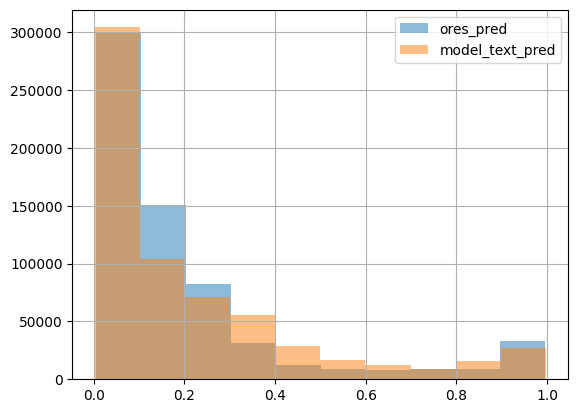

In [21]:
import matplotlib.pyplot as plt
test.ores_pred.hist(alpha=0.5, label="ores_pred")
test.model_text_pred.hist(alpha=0.5, label="model_text_pred")

plt.legend()

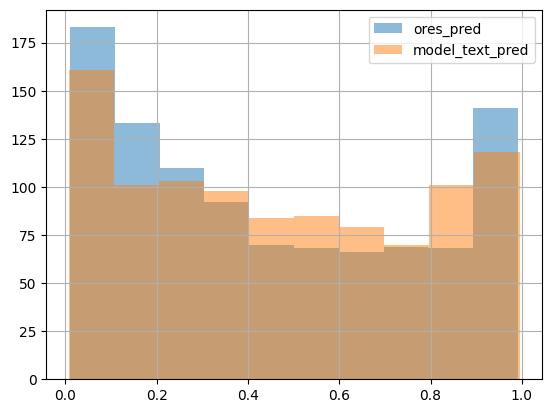

In [88]:
import matplotlib.pyplot as plt
human_test.ores_pred.hist(alpha=0.5, label="ores_pred")
human_test.model_text_pred.hist(alpha=0.5, label="model_text_pred")

plt.legend()

In [93]:
human_test[(np.abs(human_test.ores_pred - human_test.model_text_pred) > 0.3)].count()

page_title                 91
event_timestamp            91
revision_id                91
event_comment              91
revision_parent_id         91
                           ..
model_text_only_pred       91
rule_based_pred            91
ORES_score_bucket          91
Graph2Text_score_bucket    91
is_g2t                     91
Length: 74, dtype: int64

In [96]:
human_test.event_timestamp.min()

'2023-06-01 06:46:46'

In [97]:
human_test.event_timestamp.max()

'2023-08-31 20:55:42'

In [47]:
import numpy as np
selected_ids_ores = set()
selected_ids_g2t = set()
for backet_id in range(1, 11):
    np.random.seed(0)
    selected_ids_g2t |= set(np.random.choice(test[test.Graph2Text_score_bucket == backet_id].revision_id.to_list(), size=50, replace=False))
    selected_ids_ores |= set(np.random.choice(test[test.ORES_score_bucket == backet_id].revision_id.to_list(), size=50, replace=False))

In [48]:
len(selected_ids_ores) + len(selected_ids_g2t)
# Should be 1000 -> no duplicates

1000

In [53]:
human_test = test[test.revision_id.isin(selected_ids_ores | selected_ids_g2t)]
print("Length: ", len(human_test))
print("Anonymous rate: ", human_test.event_user_is_anonymous.mean())
print("Revert rate: ", human_test.revision_is_identity_reverted.mean())
print("Page age mean: ", human_test.page_age.mean())
print("User age mean: ", human_test.user_age.mean())

human_test["is_g2t"] = human_test.revision_id.isin(selected_ids_g2t)
# human_test["is_ores"] = human_test[human_test.revision_id.isin(selected_ids_ores)]
display(human_test.groupby("is_g2t").agg(
        {
            "event_user_is_anonymous": ["mean", "count"], 
            "revision_is_identity_reverted": ["mean"],
            "page_age": ["mean"],
            "user_age": ["mean"],
        }
    )
)


metrics = [
    calculate_metrics(human_test.revision_is_identity_reverted, human_test.rule_based_pred, verbose=False),
    calculate_metrics(human_test.revision_is_identity_reverted, human_test.ores_pred, verbose=False),
    calculate_metrics(human_test.revision_is_identity_reverted, human_test.model_dummy_pred, verbose=False),
    calculate_metrics(human_test.revision_is_identity_reverted, human_test.model_text_only_pred, verbose=False),
    calculate_metrics(human_test.revision_is_identity_reverted, human_test.model_text_pred, verbose=False),
]
pd.DataFrame(metrics, columns=["AUC", "±CI", "RF0.99", "RF0.9", "RF0.7"])

Length:  1000
Anonymous rate:  0.296
Revert rate:  0.167
Page age mean:  2472.572
User age mean:  876.408


/tmp/ipykernel_902001/2601798194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_test["is_g2t"] = human_test.revision_id.isin(selected_ids_g2t)


event_user_is_anonymous       revision_is_identity_reverted  page_age  \
                          mean count                          mean      mean   
is_g2t                                                                         
False                    0.334   500                         0.166  2412.998   
True                     0.258   500                         0.168  2532.146   

        user_age  
            mean  
is_g2t            
False    741.110  
True    1011.706

,AUC,±CI,RF0.99,RF0.9,RF0.7
0,0.710141,"[0.6994559006888352, 0.7198579925627545]",0.000,0.000,0.704
1,0.792355,"[0.7813522672340608, 0.8034008348271824]",0.335,0.697,0.834
2,0.814233,"[0.8043662537651262, 0.8233083105537207]",0.441,0.721,0.828
3,0.795193,"[0.7856564585945379, 0.8054663232846352]",0.374,0.652,0.819
4,0.882072,"[0.8741050780791751, 0.8895730819195403]",0.563,0.789,0.886


In [81]:
human_test.groupby(["ORES_score_bucket", "Graph2Text_score_bucket"])["page_title"].count().sort_values(ascending=False).head(10)

/tmp/ipykernel_902001/2017218907.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  human_test.groupby(["ORES_score_bucket", "Graph2Text_score_bucket"])["page_title"].count().sort_values(ascending=False).head(10)


ORES_score_bucket  Graph2Text_score_bucket
10                 10                         69
1                  1                          56
2                  1                          38
1                  2                          32
                   3                          27
10                 9                          27
1                  4                          22
3                  1                          21
9                  10                         21
1                  5                          21
Name: page_title, dtype: int64

In [98]:
human_test

,page_title,event_timestamp,revision_id,event_comment,revision_parent_id,is_bot,revision_is_identity_reverted,revision_is_identity_revert,revision_seconds_to_identity_revert,revision_first_identity_reverting_revision_id,...,user_is_bot,user_is_anonymous,ores_pred,model_dummy_pred,model_text_pred,model_text_only_pred,rule_based_pred,ORES_score_bucket,Graph2Text_score_bucket,is_g2t
381,Q4742105,2023-08-16 01:05:49,1954633434,/* wbsetclaim-create:2||1 */ [[Property:P765]]...,1952676385,0,False,False,NaN,NaN,...,0,False,0.473727,0.793603,0.492595,0.271540,0,5,5,False
2751,Q9171878,2023-07-01 22:31:19,1927222417,/* wbsetclaim-update:2||1|1 */ [[Property:P698...,1927221724,0,False,False,NaN,NaN,...,0,False,0.575766,0.539955,0.588389,0.586082,0,6,6,True
12903,Q61732255,2023-08-27 05:30:58,1962156438,/* wbsetsitelink-remove:1|frwikisource */ Le M...,1946769923,0,True,False,91587.0,1.962949e+09,...,0,False,0.966941,0.867513,0.850833,0.614244,0,10,9,False
13882,Q4688112,2023-06-23 20:43:12,1922333339,/* wbsetaliases-add:1|jbo */ Sung Jae-gi,1921411571,0,False,False,NaN,NaN,...,0,False,0.869988,0.741520,0.801237,0.728788,0,9,9,False
23738,Q121140209,2023-08-03 19:51:32,1945811900,/* wbremoveclaims-remove:1| */ [[Property:P281...,1945811865,-1,False,False,NaN,NaN,...,-1,True,0.888936,0.246925,0.700098,0.290023,1,9,8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6650356,Q7042547,2023-07-19 01:20:56,1936953216,/* wbsetdescription-add:1|ha */ Malami na Nije...,1936952810,0,False,False,NaN,NaN,...,0,False,0.699275,0.547384,0.155370,0.119503,0,8,2,False
6654444,Q4850807,2023-06-07 16:54:16,1910336686,/* wbsetclaim-update:2||1|2 */ [[Property:P197...,1901753216,0,False,False,NaN,NaN,...,0,False,0.131580,0.291463,0.405850,0.640912,0,2,5,True
6661632,Q41246802,2023-07-09 14:52:46,1931956814,/* wbsetclaim-create:2||1 */ [[Property:P463]]...,1931956493,0,False,False,NaN,NaN,...,0,False,0.029587,0.238438,0.133490,0.237093,0,1,2,True
6667132,Q63345427,2023-07-26 15:31:50,1940836002,/* wbsetlabel-add:1|nl */ stroomgebied van het...,1844065273,0,False,False,NaN,NaN,...,0,False,0.022289,0.219820,0.422090,0.656388,0,1,5,True


In [ ]:
human_data = pd.read_csv("../data/wikidata_for_labeling_1K.csv")